# Dodatkowe

## Metrics

In [ ]:
# funkcje metryk oceny jakości modelu
from keras import backend as K
import tensorflow as tf

# mierzy stopień pokrycia pomiędzy rzeczywistymi i przewidywanymi obszarami na obrazie
# y_true i y_pred - rzeczywiste i przewidywane etykiety obrazu, smooth - wartość dodana do mianownika dla stabilności obliczeń
def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

# stosunek sumy przecięcia do sumy unii pomiędzy obszarami
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    jac = (intersection + 1.) / (union - intersection + 1.)
    return K.mean(jac)

# Przekształca wartości w tensorze x na binarną postać przy użyciu określonego progu
def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

# obliczanie wskaźnika IoU po przekształceniu progowym przewidywanych etykiet
def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold) # przekształcenia przewidywanych etykiet przy użyciu określonego progu
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

# podwójna wartość przecięcia podzielona przez sumę obszarów rzeczywistych i przewidywanych
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


## Utils

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# tworzy generatory augmentacji danych na podstawie podanych obrazów i etykiet treningowych
def get_augmented(
    X_train,
    Y_train,
    X_val=None,
    Y_val=None,
    batch_size=32,
    seed=0,
    data_gen_args = dict(
        rotation_range=10.,
        #width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=5,
        #zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    )):


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)

    train_generator = zip(X_train_augmented, Y_train_augmented)

    if not (X_val is None) and not (Y_val is None):
        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator(**data_gen_args)
        Y_datagen_val = ImageDataGenerator(**data_gen_args)
        X_datagen_val.fit(X_val, augment=True, seed=seed)
        Y_datagen_val.fit(Y_val, augment=True, seed=seed)
        X_val_augmented = X_datagen_val.flow(X_val, batch_size=batch_size, shuffle=True, seed=seed)
        Y_val_augmented = Y_datagen_val.flow(Y_val, batch_size=batch_size, shuffle=True, seed=seed)

        # combine generators into one which yields image and masks
        val_generator = zip(X_val_augmented, Y_val_augmented)

        return train_generator, val_generator
    else:
        return train_generator

# Wyświetla wykresy metryk (np. IoU) i strat w zależności od liczby epok w historii treningu modelu segmentacji semantycznej
def plot_segm_history(history, metrics=['iou', 'val_iou'], losses=['loss', 'val_loss']):
    # summarize history for iou
    plt.figure(figsize=(12,6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle('metrics over epochs', fontsize=20)
    plt.ylabel('metric', fontsize=20)
    plt.xlabel('epoch', fontsize=20)
    #plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    #plt.xticks(fontsize=35)
    plt.legend(metrics, loc='center right', fontsize=15)
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(12,6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle('loss over epochs', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.xlabel('epoch', fontsize=20)
    #plt.yticks(np.arange(0, 0.2, step=0.005), fontsize=35)
    #plt.xticks(fontsize=35)
    plt.legend(losses, loc='center right', fontsize=15)
    plt.show()

# dwie poniższe funkcje konwertują binarną maskę segmentacji (białe piksele) na obrazy kolorowe
# zwraca obrazy w formacie RGBA, w których maska segmentacji jest czerwona, a tło jest czarne
def mask_to_red(mask):
    '''
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    '''
    img_size = mask.shape[0]
    c1 = mask.reshape(img_size,img_size)
    c2 = np.zeros((img_size,img_size))
    c3 = np.zeros((img_size,img_size))
    c4 = mask.reshape(img_size,img_size)
    return np.stack((c1, c2, c3, c4), axis=-1)

# pozwala wybrać kolor maski segmentacji spośród kilku dostępnych opcji
def mask_to_rgba(mask, color='red'):
    '''
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    '''
    img_size = mask.shape[0]
    zeros = np.zeros((img_size,img_size))
    ones = mask.reshape(img_size,img_size)
    if color == 'red':
        return np.stack((ones, zeros, zeros, ones), axis=-1)
    elif color == 'green':
        return np.stack((zeros, ones, zeros, ones), axis=-1)
    elif color == 'blue':
        return np.stack((zeros, zeros, ones, ones), axis=-1)
    elif color == 'yellow':
        return np.stack((ones, ones, zeros, ones), axis=-1)
    elif color == 'magenta':
        return np.stack((ones, zeros, ones, ones), axis=-1)
    elif color == 'cyan':
        return np.stack((zeros, ones, ones, ones), axis=-1)

# wyświetla zestawienie obrazów wraz z odpowiadającymi im etykietami i/lub predykcjami modelu
# ostatnia kolumna zawiera nakładkę etykiety lub predykcji na obraz oryginalny.
def plot_imgs(org_imgs,
              mask_imgs,
              pred_imgs=None,
              nm_img_to_plot=10,
              figsize=4,
              alpha=0.5
             ):
    '''
    Image plotting for semantic segmentation data.
    Last column is always an overlay of ground truth or prediction
    depending on what was provided as arguments.
    '''
    if nm_img_to_plot > org_imgs.shape[0]:
        nm_img_to_plot = org_imgs.shape[0]
    im_id = 0
    org_imgs_size = org_imgs.shape[1]

    org_imgs = reshape_arr(org_imgs)
    mask_imgs = reshape_arr(mask_imgs)
    if  not (pred_imgs is None):
        cols = 4
        pred_imgs = reshape_arr(pred_imgs)
    else:
        cols = 3


    fig, axes = plt.subplots(nm_img_to_plot, cols, figsize=(cols*figsize, nm_img_to_plot*figsize))
    axes[0, 0].set_title("original", fontsize=15)
    axes[0, 1].set_title("ground truth", fontsize=15)
    if not (pred_imgs is None):
        axes[0, 2].set_title("prediction", fontsize=15)
        axes[0, 3].set_title("overlay", fontsize=15)
    else:
        axes[0, 2].set_title("overlay", fontsize=15)
    for m in range(0, nm_img_to_plot):
        axes[m, 0].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
        axes[m, 0].set_axis_off()
        axes[m, 1].imshow(mask_imgs[im_id], cmap=get_cmap(mask_imgs))
        axes[m, 1].set_axis_off()
        if not (pred_imgs is None):
            axes[m, 2].imshow(pred_imgs[im_id], cmap=get_cmap(pred_imgs))
            axes[m, 2].set_axis_off()
            axes[m, 3].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 3].imshow(mask_to_red(zero_pad_mask(pred_imgs[im_id], desired_size=org_imgs_size)), cmap=get_cmap(pred_imgs), alpha=alpha)
            axes[m, 3].set_axis_off()
        else:
            axes[m, 2].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 2].imshow(mask_to_red(zero_pad_mask(mask_imgs[im_id], desired_size=org_imgs_size)), cmap=get_cmap(mask_imgs), alpha=alpha)
            axes[m, 2].set_axis_off()
        im_id += 1

    plt.show()
    return fig, axes

# dwie poniższe funkcje przetwarzają maski segmentacji, aby miały określony rozmiar
# dodaje padding wokół maski, aby doprowadzić ją do określonego rozmiaru
def zero_pad_mask(mask, desired_size):
    pad = (desired_size - mask.shape[0]) // 2
    padded_mask = np.pad(mask, pad, mode="constant")
    return padded_mask

# zmienia kształt tablicy, aby uwzględnić różne wymiary i kanały obrazów
def reshape_arr(arr):
    if arr.ndim == 3:
        return arr
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return arr
        elif arr.shape[3] == 1:
            return arr.reshape(arr.shape[0], arr.shape[1], arr.shape[2])

# służy do określania mapy kolorów używanej do wizualizacji tablicy obrazów
def get_cmap(arr):
    if arr.ndim == 3:
        return 'gray'
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return 'jet'
        elif arr.shape[3] == 1:
            return 'gray'

# dwie poniższe funkcje odpowiadają za podział obrazu na fragmenty za pomocą metody przesuwnego okna
# zwraca tablicę fragmentów obrazu, które można wykorzystać do treningu modelu segmentacji semantycznej
def get_patches(img_arr, size=256, stride=256):
    '''
    Takes single image or array of images and returns
    crops using sliding window method.
    If stride < size it will do overlapping.
    '''
    # check size and stride
    if size % stride != 0:
        raise ValueError('size % stride must be equal 0')


    patches_list = []
    overlapping = 0
    if stride != size:
        overlapping = (size // stride) - 1

    if img_arr.ndim == 3:
        i_max = img_arr.shape[0] // stride-overlapping

        for i in range(i_max):
            for j in range(i_max):
                #print(i*stride, i*stride+size)
                #print(j*stride, j*stride+size)
                patches_list.append(
                    img_arr[i*stride:i*stride+size,
                            j*stride:j*stride+size
                           ])

    elif img_arr.ndim == 4:
        i_max = img_arr.shape[1] // stride - overlapping
        for im in img_arr:
            for i in range(i_max):
                for j in range(i_max):
                    #print(i*stride, i*stride+size)
                    #print(j*stride, j*stride+size)
                    patches_list.append(
                        im[i*stride:i*stride+size,
                           j*stride:j*stride+size
                          ])

    else:
        raise ValueError('img_arr.ndim must be equal 3 or 4')

    return np.stack(patches_list)

# wyświetla fragmenty obrazu, próbując odtworzyć oryginalny obraz na podstawie fragmentów
def plot_patches(img_arr, org_img_size, stride=None, size=None):
    '''
    Plots all the patches for the first image in 'img_arr' trying to reconstruct the original image
    '''

    # check parameters
    if type(org_img_size) is not tuple:
        raise ValueError('org_image_size must be a tuple')

    if img_arr.ndim == 3:
        img_arr = np.expand_dims(img_arr, axis=0)

    if size is None:
        size = img_arr.shape[1]

    if stride is None:
        stride = size

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    fig, axes = plt.subplots(i_max, j_max, figsize=(i_max*2, j_max*2))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    jj = 0
    for i in range(i_max):
        for j in range(j_max):
            axes[i, j].imshow(img_arr[jj])
            axes[i, j].set_axis_off()
            jj += 1

# Przywraca oryginalny obraz na podstawie fragmentów obrazu otrzymanych za pomocą funkcji get_patches
def reconstruct_from_patches(img_arr, org_img_size, stride=None, size=None):
    # check parameters
    if type(org_img_size) is not tuple:
        raise ValueError('org_image_size must be a tuple')

    if img_arr.ndim == 3:
        img_arr = np.expand_dims(img_arr, axis=0)

    if size is None:
        size = img_arr.shape[1]

    if stride is None:
        stride = size

    nm_layers = img_arr.shape[3]

    i_max = (org_img_size[0] // stride) + 1 - (size // stride)
    j_max = (org_img_size[1] // stride) + 1 - (size // stride)

    total_nm_images = (img_arr.shape[0]//(i_max**2))
    nm_images = img_arr.shape[0]

    averaging_value = (size//stride)
    images_list = []
    kk = 0
    for img_count in range(total_nm_images):
        img_bg = np.zeros((org_img_size[0], org_img_size[1], nm_layers), dtype=img_arr[0].dtype)

        for i in range(i_max):
            for j in range(j_max):
                for layer in range(nm_layers):
                    img_bg[i*stride:i*stride+size, j*stride:j*stride+size, layer] = img_arr[kk,:,:,layer]

                kk += 1
        images_list.append(img_bg)

    return np.stack(images_list)

## Unet Model

In [ ]:
from keras.models import Model
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D, Input, concatenate

def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)

# definiuje blok konwolucyjny, który składa się z dwóch warstw konwolucyjnych, opcjonalnej warstwy normalizacji wsadowej
# i opcjonalnej warstwy dropout
def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    filters=16,
    kernel_size=(3,3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'):

    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = Dropout(dropout)(c)
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c

# tworzy model U-Net, używając wcześniej zdefiniowanych bloków konwolucyjnych, warstw redukcji próbek i warstw powiększających obraz
def unet_model(
    input_shape,
    num_classes=1,
    use_batch_norm=True,
    upsample_mode='deconv', # 'deconv' or 'simple'
    use_dropout_on_upsampling=False,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    filters=16,
    num_layers=4,
    output_activation='sigmoid'): # 'sigmoid' or 'softmax'

    if upsample_mode=='deconv':
        upsample=upsample_conv
    else:
        upsample=upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    x = inputs

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)
        down_layers.append(x)
        x = MaxPooling2D((2, 2)) (x)
        dropout += dropout_change_per_layer
        filters = filters*2 # double the number of filters with each layer

    x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2 # decreasing number of filters with each layer
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding='same') (x)
        x = concatenate([x, conv])
        x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)

    outputs = Conv2D(num_classes, (1, 1), activation=output_activation) (x)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# Train Code


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import sys
from PIL import Image
from sklearn.model_selection import train_test_split
# from unet_model import unet_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
# from metrics import iou, iou_thresholded
from pandas import DataFrame
from PIL import Image, ImageOps

In [ ]:
# wczytywanie obrazu o podanej ścieżce fn i zadanym rozmiarze img_size
def load_image(fn, img_size):
    im = Image.open(fn).resize(img_size, Image.NEAREST) # zmniejszanie obrazu do określonego rozmiaru
    im = ImageOps.exif_transpose(im) # obrócenie obrazu, jeśli zawiera informacje o orientacji w formacie EXIF
    im = im.convert("L") # konwersja obrazu do skali szarości
    im_array = np.array(im)
    return im_array # zwrócenie w postaci tablicy

# to samo, co wyżej (bez konwersji)
def load_label(fn, img_size):
    im = Image.open(fn).resize(img_size, Image.NEAREST)
    im = ImageOps.exif_transpose(im)
    # im = im.convert("L")
    im_array = np.array(im)
    return im_array

# def load_data(path_to_raw, path_to_labels, img_size):
#     # Load images
#     image_files = sorted(glob(path_to_raw + '/*.jpg'))
#     images = np.stack([load_image(filename, img_size) for filename in image_files])

#     # Load labels
#     label_files = sorted(glob(path_to_labels + '/*.png'))
#     labels = np.stack([load_image(filename, img_size) for filename in label_files])

#     return images, labels

# wczytywanie danych obrazowych i etykiet
# tworzy listę plików obrazów i etykiet, sortuje je
# i następnie wczytuje je przy użyciu wcześniej zdefiniowanych funkcji load_image i load_label
def load_data(path_to_raw, path_to_labels, img_size):
    # Load images
    image_files = sorted(glob(path_to_raw + '/*.jpg'))
    images = np.stack([load_image(filename, img_size) for filename in image_files])

    # Load labels
    label_files = sorted(glob(path_to_labels + '/*.png'))
    labels = np.stack([load_image(filename, img_size) for filename in label_files])

    for i in range(len(image_files)):
      f = image_files[i].split("/")[6]
      l = label_files[i].split("/")[6]
      print(f"{f} {l}")

    return images, labels, label_files

In [ ]:
path_to_data = '/content/drive/MyDrive/CollabData/Boxes'
image_size = (256, 256)

imgs_np, masks_np, _ = load_data(path_to_data, path_to_data, image_size)

ValueError: ignored

In [ ]:
# print(masks_np.shape)
# masks3_np = masks_np + masks_np + masks_np
# print(masks3_np.shape)

In [ ]:
# normalize data
# normalizuje dane obrazów imgs_np przez podzielenie ich przez maksymalną wartość piksela w imgs_np i wynik przypisuje do x
x = np.asarray(imgs_np, dtype=np.float32) / np.max(imgs_np)
y = np.asarray(masks_np, dtype=np.float32) / 0xff

print(f"x min:{x.min()} max:{x.max()}")
print(f"y min:{y.min()} max:{y.max()}")

# reshape data for keras
# zmienia kształt y, dodając nową osi na końcu, aby pasowało do wymagań wejścia modelu
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(f"masks shape:{y.shape}")

x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(f"images shape:{x.shape}")

# split data for train and test data
# dzieli dane na zestawy treningowe i walidacyjne
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=0)

# wyświetlanie kształtów danych treningowych
print(f"x_train shape:{x_train.shape}")
print(f"y_train shape:{y_train.shape}")

# wyświetlanie kształtów danych walidacyjnych
print(f"x_val shape:{x_val.shape}")
print(f"y_val shape:{y_val.shape}")

# Initialize network

input_shape = x_train[0].shape

# tworzenie modelu U-Net
model = unet_model(
      input_shape,
      num_classes=1,
      filters=64,
      dropout=0.2,
      num_layers=4,
      output_activation='sigmoid'
)

# Compile + train

model_filename = 'unet_model.h5'
# tworzy obiekt , który będzie monitorował wartość funkcji straty dla zbioru walidacyjnego ('val_loss')
# i zapisze tylko najlepszy model (save_best_only=True) do pliku o nazwie model_filename
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

# będzie monitorował wartość funkcji straty dla zbioru walidacyjnego ('val_loss') i zatrzyma trening,
# jeśli wartość funkcji straty nie zmniejszy się przez 10 epok (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

model.compile(
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)
# model.summary()
history = model.fit(
    x_train, y_train, batch_size=32,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[callback_checkpoint, early_stopping],
    shuffle=True
)



NameError: ignored

# Test Code


x max:1.0
y max:1.0
1/1 [==============================] - 9s 9s/step
Prediction of 19 images in 9.46s


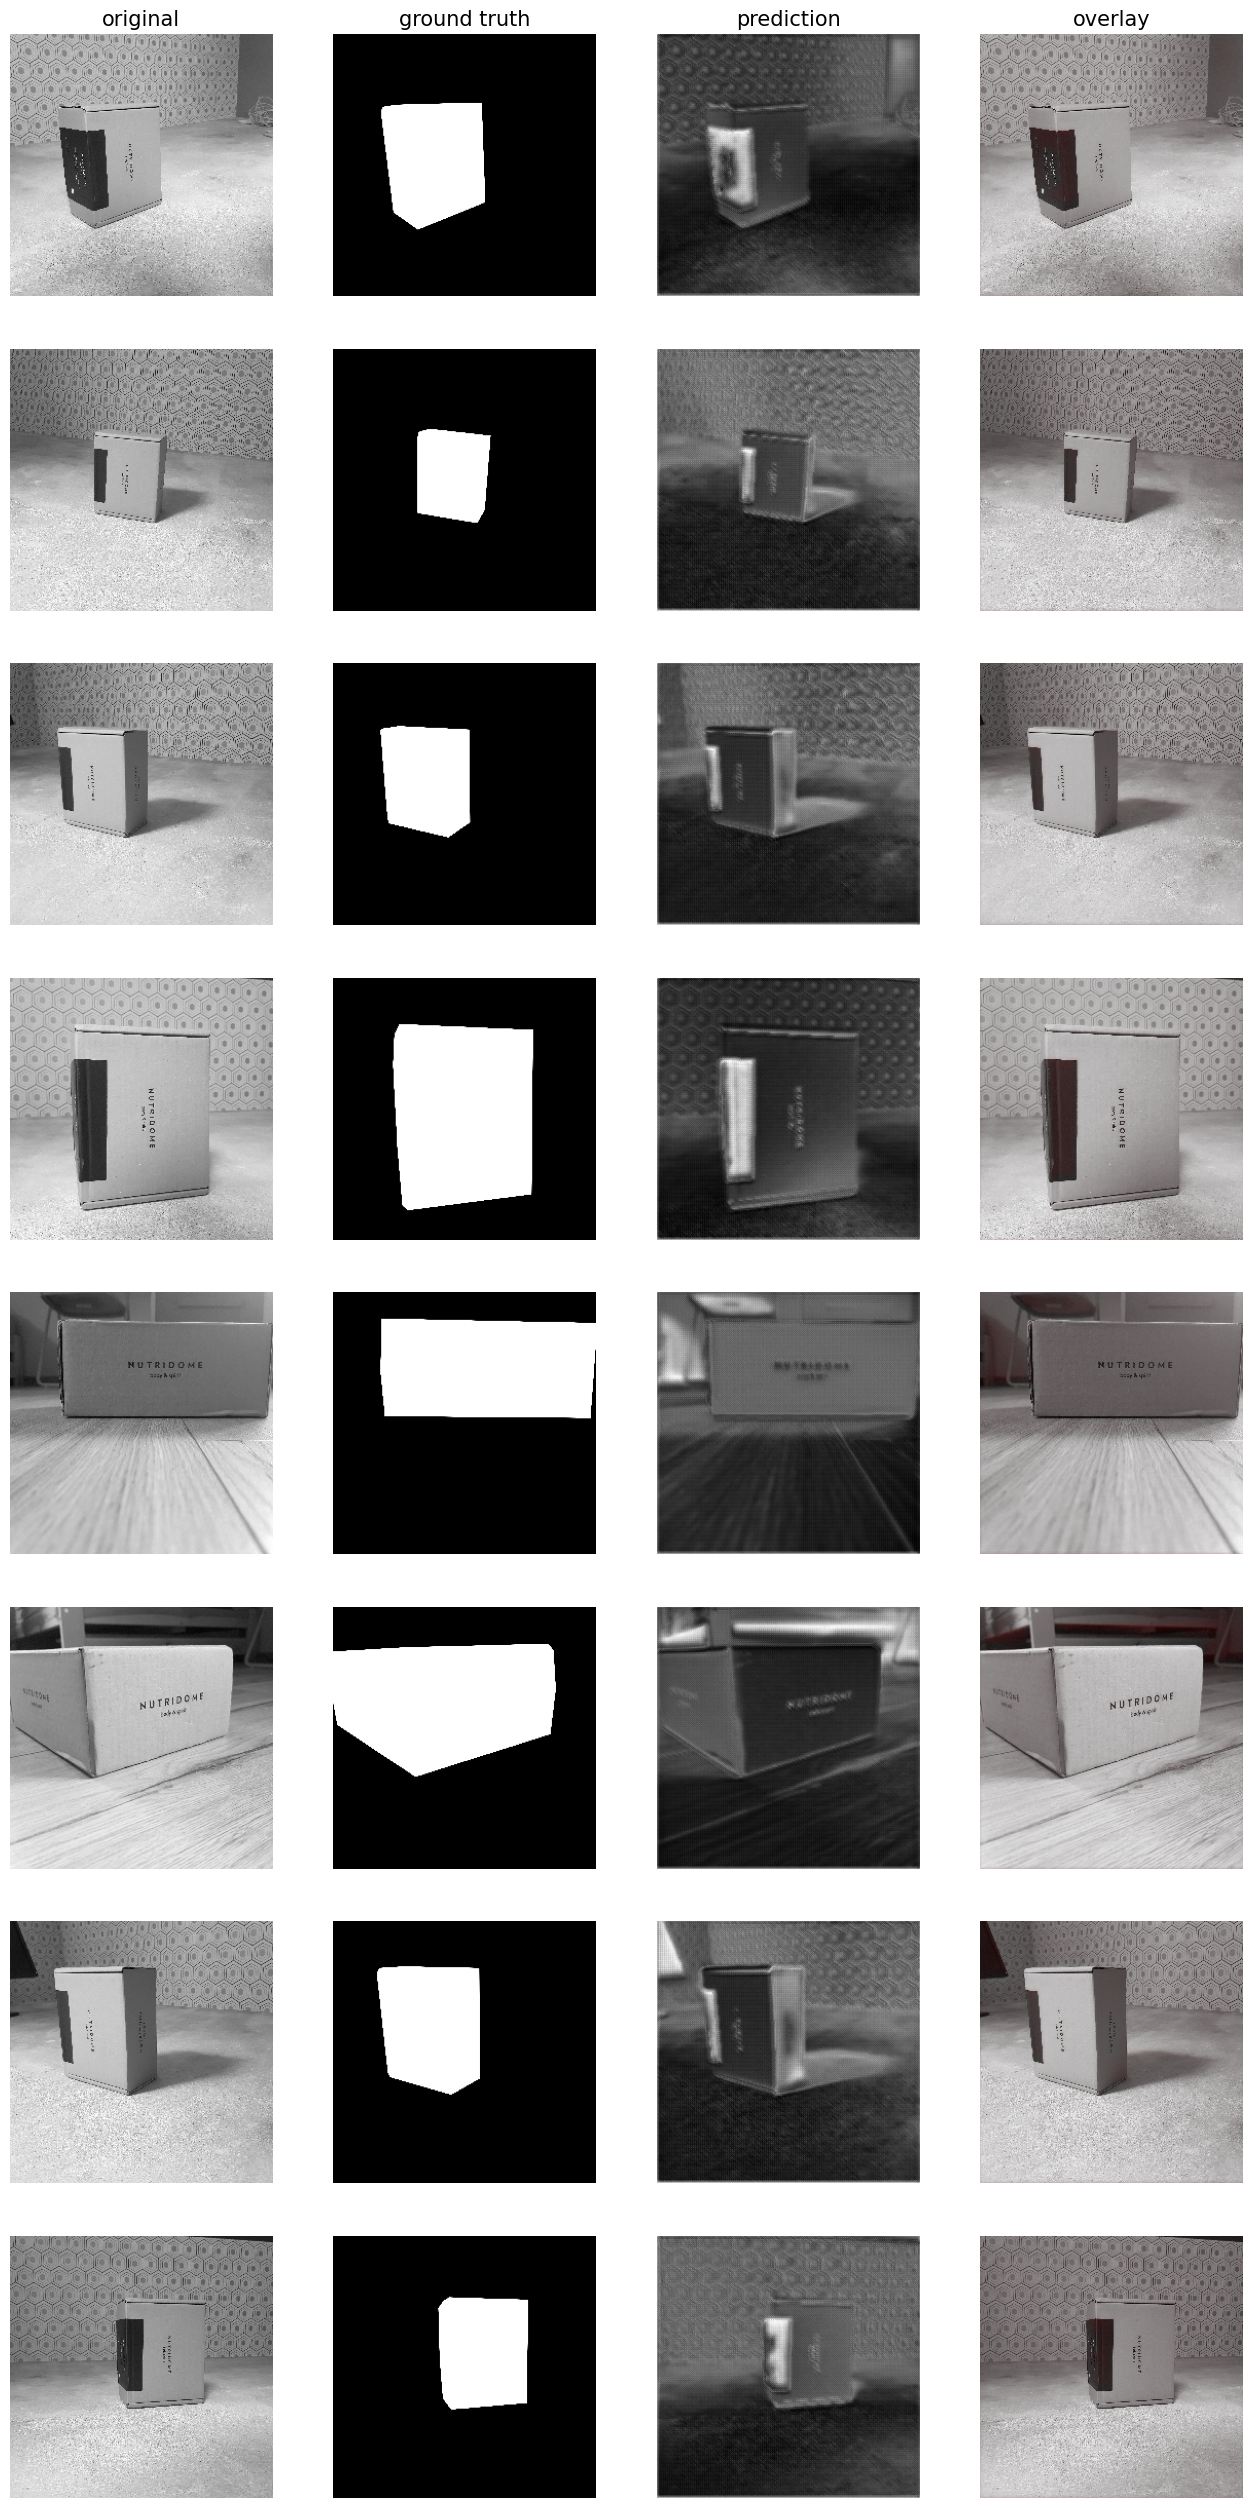

In [ ]:
from PIL import Image, ExifTags
import numpy as np
from glob import glob
# from unet_model import unet_model
# from utils import plot_imgs
from os.path import join, exists, basename
from os import makedirs
import matplotlib.pyplot as plt

# wczytywanie modeli, przeprowadzenie predykcji na obrazach testowych i wyświetlenie wyników

path_to_data = '/content/drive/MyDrive/CollabData/TestImages'
path_to_results = '/content/drive/MyDrive/CollabData/Segmentations'

image_size = (256, 256)


# def load_image(fn, img_size):
#     im = Image.open(fn).resize(img_size, Image.NEAREST)
#     grey_image = im.convert("L")
#     im_array = np.array(grey_image)
#     return im_array


def test_model(display_plot=True, save_predictions=False):
    # wczytanie obrazów i etykiet
    imgs_np, masks_np, label_files = load_data(path_to_data, path_to_data, image_size)

    # konwertuje imgs_np na tablicę NumPy i normalizuje wartości pikseli do zakresu od 0 do 1, a wynik przypisuje do zmiennej x
    x = (np.asarray(imgs_np, dtype=np.float32) / 255)
    y = (np.asarray(masks_np, dtype=np.float32) / 255)

    print(f"x max:{x.max()}")
    print(f"y max:{y.max()}")

    # przekształca tablicę x do odpowiedniego kształtu, aby pasowała do wejścia modelu, a wynik przypisuje do x_val
    x_val = x.reshape(x.shape[0], x.shape[1], x.shape[2], -1)
    y_val = y.reshape(y.shape[0], y.shape[1], y.shape[2], -1)

    # przypisuje kształt pierwszego elementu w x_val do zmiennej input_shape
    input_shape = x_val[0].shape

    # tworzy model U-Net za pomocą funkcji unet_model z określonymi parametrami, a wynik przypisuje do zmiennej model
    model = unet_model(
        input_shape,
        num_classes=1,
        filters=64,
        dropout=0.2,
        num_layers=4,
        output_activation='sigmoid'
    )

    model_filename = '/content/unet_model.h5'
    model.load_weights(model_filename)

    from time import time

    # zapisuje bieżący czas w zmiennej
    start = time()
    # wykonuje predykcję na danych testowych x_val
    y_pred = model.predict(x_val)
    # zapisuje bieżący czas w zmiennej
    end = time()
    # wyświetla informacje o liczbie przewidywanych obrazów i czasie trwania predykcji
    print(f'Prediction of {len(y_pred):d} images in {end - start:.2f}s')

    if display_plot:
        # generuje losową permutację indeksów od 0 do długości x_val i przypisuje do p
        p = np.random.permutation(len(x_val))
        # określa liczbę obrazów testowych do wyświetlenia
        num_tests = 8
        # wywołuje funkcję, która generuje wykresy z obrazami oryginalnymi, etykietami i predykcjami
        fig, _ = plot_imgs(org_imgs=x_val[p], mask_imgs=y_val[p], pred_imgs=y_pred[p], nm_img_to_plot=num_tests)
        # ustawia rozmiar wykresu na 8x10 cali
        fig.set_size_inches(8, 10)

    if save_predictions:
        # sprawdza, czy folder path_to_results nie istnieje, i tworzy go, jeśli to konieczne
        if not exists(path_to_results):
            makedirs(path_to_results)

        for i, segmentation in enumerate(y_pred):
            # wydobywa nazwę pliku z pełnej ścieżki label_files[i]
            filename = basename(label_files[i])
            # zamienia część napisu "roi" na "seg" w nazwie pliku
            filename = filename.replace('roi', 'seg')
            # tworzy obiekt Image z tablicy segmentation, skaluje wartości pikseli do zakresu od 0 do 255,
            # konwertuje na typ uint8 i przypisuje do im
            im = Image.fromarray(np.squeeze(segmentation * 255).astype('uint8'), 'L')
            im.save(join(path_to_results, filename))


if __name__ == '__main__':
    test_model(display_plot=True, save_predictions=False)
